In [1]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# LOADING THE NECESSARY LIBRARIES

In [21]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf

In [ ]:
import pandas as pd
import io
from google.colab import files

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# IMPORTING THE DATASET

In [2]:
url = 'https://raw.githubusercontent.com/lutzhamel/fake-news/master/data/fake_or_real_news.csv'

In [3]:
data = pd.read_csv(url)

In [13]:
data['text'][2]

'U.S. Secretary of State John F. Kerry said Monday that he will stop in Paris later this week, amid criticism that no top American officials attended Sunday’s unity march against terrorism.\n\nKerry said he expects to arrive in Paris Thursday evening, as he heads home after a week abroad. He said he will fly to France at the conclusion of a series of meetings scheduled for Thursday in Sofia, Bulgaria. He plans to meet the next day with Foreign Minister Laurent Fabius and President Francois Hollande, then return to Washington.\n\nThe visit by Kerry, who has family and childhood ties to the country and speaks fluent French, could address some of the criticism that the United States snubbed France in its darkest hour in many years.\n\nThe French press on Monday was filled with questions about why neither President Obama nor Kerry attended Sunday’s march, as about 40 leaders of other nations did. Obama was said to have stayed away because his own security needs can be taxing on a country, 

In [11]:
data.iloc[2]

id                                                    3608
title          Kerry to go to Paris in gesture of sympathy
text     U.S. Secretary of State John F. Kerry said Mon...
label                                                 REAL
Name: 2, dtype: object

In [ ]:
len(data[data.label =='REAL'])

3171

# DATA VISUALIZATION AND PREPROCESSING

In [14]:
data.head()

id  ... label
0   8476  ...  FAKE
1  10294  ...  FAKE
2   3608  ...  REAL
3  10142  ...  FAKE
4    875  ...  REAL

[5 rows x 4 columns]

In [15]:
data = data.replace(to_replace ="FAKE",
                 value =1)



In [16]:
data = data.replace(to_replace ="REAL",
                 value =0)


In [17]:
df = data

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


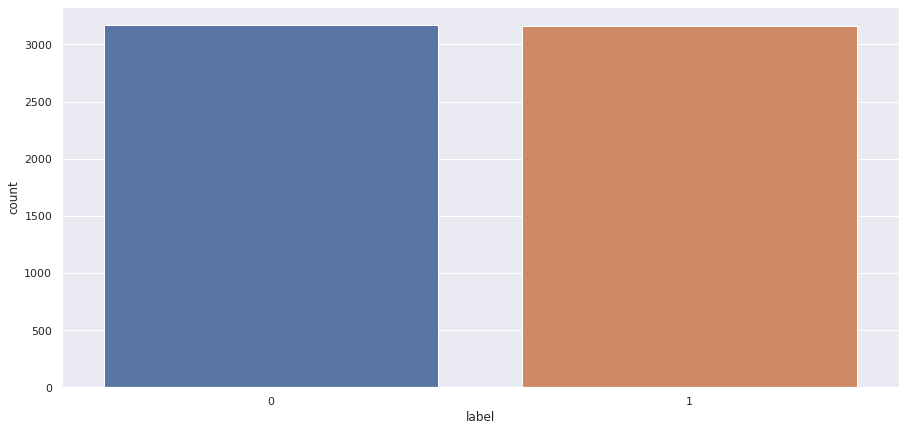

In [ ]:
plt.figure(figsize=(15,7))
sns.set(style="darkgrid")
sns.countplot(df['label'])

**SO, WE CAN SEE THAT THE DATASET IS BALANCED**

In [ ]:
df.head()

id  ... label
0   8476  ...     1
1  10294  ...     1
2   3608  ...     0
3  10142  ...     1
4    875  ...     0

[5 rows x 4 columns]

In [ ]:
df.isna().sum() # Checking for nan Values

id       0
title    0
text     0
label    0
dtype: int64

**MERGING ALL THE TEXT DATA INTO 1 COLUMN i.e. 'text'**

In [ ]:
# Merging title and text
df['text'] = df['title'] + ' ' + df['text']




# Randomize the rows so its all mixed up
df = df.sample(frac=1).reset_index(drop=True)

# Drop columns not needed
df = df.drop(['title'], axis = 1)
df = df.sample(frac=1)
df.head(10)

**WHAT ARE STOPWORDS?**

**Stopwords are the English words which does not add much meaning to a sentence. They can safely be ignored without sacrificing the meaning of the sentence. For example, the words like the, he, have etc. Such words are already captured this in corpus named corpus. We first download it to our python environment.**

In [19]:
import nltk
nltk.download('stopwords')
  

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [22]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

**DATA CLEANING**

In [24]:
df.iloc[0]

id                                                   10532
text     Ex-rep: 'If Trump loses, I'm grabbing my muske...
label                                                    1
Name: 569, dtype: object

In [25]:
df['text'][0]

'Cory Booker: Senate bill is "in my lifetime the first reversal of mass incarceration" Sen. Cory Booker acknowledges that the Senate\'s criminal justice bill is not perfect. But he doesn\'t hesitate to point out that "it\'s in my lifetime the first reversal of mass incarceration in the federal level."\n\nThe legislation contains some big compromises: It keeps many mandatory minimum sentences, does not shorten sentences for violent offenders, and adds a new mandatory sentencing enhancement for fentanyl, a powerful opioid, when it\'s present in trafficked heroin. Booker said that if it were only up to him, the legislation would have gone much further in rolling back punishments, and it wouldn\'t have added the mandatory enhancement for fentanyl.\n\nBut he argued that at the end of the day, the bill would be progress, leading to fewer people in federal prisons. It would reduce some mandatory minimum sentences — retroactively for nonviolent offenders. It would give judges the power to down

In [27]:
df['text'][0]

'Cory Booker Senate bill lifetime first reversal mass incarceration Sen Cory Booker acknowledges Senates criminal justice bill perfect doesnt hesitate point lifetime first reversal mass incarceration federal level legislation contains big compromises keeps many mandatory minimum sentences shorten sentences violent offenders adds new mandatory sentencing enhancement fentanyl powerful opioid present trafficked heroin Booker said legislation would gone much rolling back punishments wouldnt added mandatory enhancement fentanyl argued end day bill would progress leading fewer people federal prisons would reduce mandatory minimum sentences — retroactively nonviolent offenders would give judges power downgrade 10year mandatory minimum sentences firsttime drug offenders would let people currently prison take steps reduce length sentences special programs long demonstrate longer pose threat society Booker argued enough make law net good progressive senator said people get board Heres conversati

In [26]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()
def rem_punctuation(text):
  return text.translate(str.maketrans('','',string.punctuation))
#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = rem_punctuation(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
#Apply function on review column
df['text']=df['text'].apply(denoise_text)

In [ ]:
df.head()

id                                               text  label
5741  5773  Trump Supporters Lose Control Violently Harass...      1
1990  5699  Simon Parkes Updates Swiss Earthquakes DOS att...      1
933   1542  Muslim debate seizes GOP presidential race deb...      0
767    788  Hillary Clinton wins even loses Thats Democrat...      0
648    777  Trumps women problem CNN thing women Donald J ...      0

In [ ]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(df['text'])
corpus[:5]

['Trump', 'Supporters', 'Lose', 'Control', 'Violently']

In [ ]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'Clinton': 14830,
 'Trump': 18916,
 'US': 9022,
 'also': 7979,
 'campaign': 7265,
 'one': 9566,
 'people': 10471,
 'said': 21079,
 'would': 12529,
 '—': 8814}

**Splitting the data into 2 parts - training and testing data**

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(df['text'],df['label'],random_state = 1)

In [ ]:
max_features = 10000
maxlen = 300

In [ ]:
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)
tokenized_train = tokenizer.texts_to_sequences(x_train)
x_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen)

In [ ]:
tokenized_test = tokenizer.texts_to_sequences(x_test)
X_test = sequence.pad_sequences(tokenized_test, maxlen=maxlen)

# Introduction to GloVe
**GloVe method is built on an important idea,
You can derive semantic relationships between words from the co-occurrence matrix.
Given a corpus having V words, the co-occurrence matrix X will be a V x V matrix, where the i th row and j th column of X, X_ij denotes how many times word i has co-occurred with word j. An example co-occurrence matrix might look as follows.**
![image.png](attachment:image.png)

**The co-occurrence matrix for the sentence “the cat sat on the mat” with a window size of 1. As you probably noticed it is a symmetric matrix.
How do we get a metric that measures semantic similarity between words from this? For that, you will need three words at a time. Let me concretely lay down this statement.**

In [ ]:
!pip install kaggle

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rakibulshezan","key":"d6956859467d11693eb8f842bd380125"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d bertcarremans/glovetwitter27b100dtxt

 99% 392M/397M [00:03<00:00, 125MB/s]
100% 397M/397M [00:03<00:00, 116MB/s]


In [ ]:
from zipfile import ZipFile
file_name = 'glovetwitter27b100dtxt.zip'

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
EMBEDDING_FILE = '/content/glove.twitter.27B.100d.txt'

In [ ]:
def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))

In [ ]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
#change below line if computing normal stats is too slow
embedding_matrix = embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


**Some Model Parameters**

In [ ]:
batch_size = 256
epochs = 10
embed_size = 100

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

# TRAINING THE MODEL

In [ ]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(max_features, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False))
#LSTM 
model.add(LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25))
model.add(LSTM(units=64 , recurrent_dropout = 0.1 , dropout = 0.1))
model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 100)          1000000   
_________________________________________________________________
lstm (LSTM)                  (None, 300, 128)          117248    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,168,769
Trainable params: 168,769
Non-trainable params: 1,000,000
_________________________________________________________________


In [ ]:
history = model.fit(x_train, y_train, batch_size = batch_size , validation_data = (X_test,y_test) , epochs = 20 , callbacks = [learning_rate_reduction])

Epoch 1/20
19/19 [==============================] - 110s 5s/step - loss: 0.6318 - accuracy: 0.6369 - val_loss: 0.5785 - val_accuracy: 0.7045
Epoch 2/20
19/19 [==============================] - 92s 5s/step - loss: 0.4929 - accuracy: 0.7653 - val_loss: 0.4981 - val_accuracy: 0.7525
Epoch 3/20
19/19 [==============================] - 98s 5s/step - loss: 0.4611 - accuracy: 0.7830 - val_loss: 0.5233 - val_accuracy: 0.7128
Epoch 4/20
19/19 [==============================] - 90s 5s/step - loss: 0.4423 - accuracy: 0.8015 - val_loss: 0.3557 - val_accuracy: 0.8485
Epoch 5/20
19/19 [==============================] - 91s 5s/step - loss: 0.3336 - accuracy: 0.8550 - val_loss: 0.2848 - val_accuracy: 0.8864
Epoch 6/20
19/19 [==============================] - 91s 5s/step - loss: 0.2671 - accuracy: 0.8874 - val_loss: 0.2607 - val_accuracy: 0.8876
Epoch 7/20
19/19 [==============================] - 90s 5s/step - loss: 0.2088 - accuracy: 0.9141 - val_loss: 0.2391 - val_accuracy: 0.9059
Epoch 8/20
19/19 [=

In [ ]:
pip install torchvision 

In [ ]:
model = tf.keras.models.load_model('/content/gdrive/MyDrive/Thesis/FakeorReal/lstmmodel')

# Check its architecture
model.summary()

In [ ]:
model.save('/content/gdrive/MyDrive/Thesis/FakeorReal/lstmmodel') 

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Thesis/FakeorReal/lstmmodel/assets


# ANALYSIS AFTER TRAINING OF MODEL

In [ ]:
print("Accuracy of the model on Training Data is - " , model.evaluate(x_train,y_train)[1]*100 , "%")
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

149/149 [==============================] - 23s 154ms/step - loss: 0.0014 - accuracy: 1.0000
Accuracy of the model on Training Data is -  100.0 %
50/50 [==============================] - 8s 150ms/step - loss: 0.3355 - accuracy: 0.9236
Accuracy of the model on Testing Data is -  92.36111044883728 %


In [ ]:
pred = model.predict_classes(X_test)
pred[:5]

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([[1],
       [0],
       [1],
       [1],
       [0]], dtype=int32)

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
f1 = f1_score(y_true=y_test, y_pred=pred)
print(f'f1: {f1}')

f1: 0.9227823867262285


In [ ]:
print(classification_report(y_test, pred, target_names = ['Not Fake','Fake']))

              precision    recall  f1-score   support

    Not Fake       0.93      0.92      0.92       803
        Fake       0.92      0.93      0.92       781

    accuracy                           0.92      1584
   macro avg       0.92      0.92      0.92      1584
weighted avg       0.92      0.92      0.92      1584



In [ ]:
cm = confusion_matrix(y_test,pred)
cm

array([[740,  63],
       [ 58, 723]])

In [ ]:
cm = pd.DataFrame(cm , index = ['Original','Fake',] , columns = ['Original','Fake'])

Text(66.5, 0.5, 'Actual')

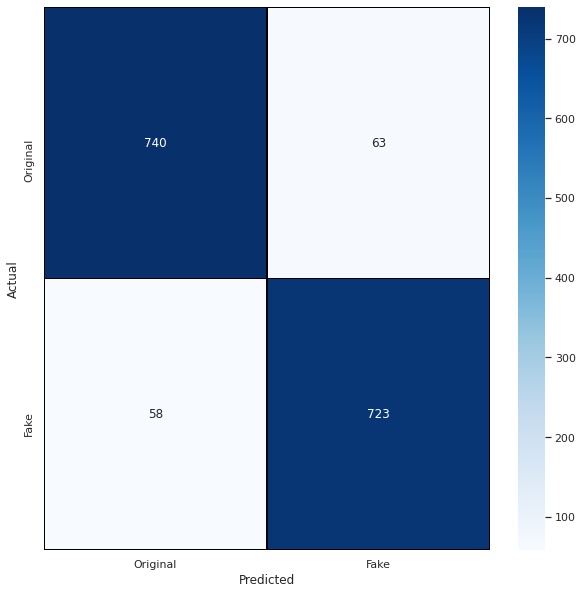

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Original','Fake'] , yticklabels = ['Original','Fake'])
plt.xlabel("Predicted")
plt.ylabel("Actual")

# CNN

In [ ]:
# build a 1D convnet with global maxpooling                                                                      

from keras import layers
from keras.models import Sequential

model2 = Sequential(
    [
        # part 1: word and sequence processing
        layers.Embedding(max_features, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False),
        layers.Conv1D(128, 5, activation='relu'),
        layers.GlobalMaxPooling1D(),
        
        # part 2: classification
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

model2.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 100)          1000000   
_________________________________________________________________
conv1d (Conv1D)              (None, 296, 128)          64128     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 1,080,769
Trainable params: 80,769
Non-trainable params: 1,000,000
_________________________________________________________________


In [ ]:
# train the model

history = model2.fit(x_train, y_train, batch_size = batch_size , validation_data = (X_test,y_test) , epochs = 20 , callbacks = [learning_rate_reduction])

Epoch 1/20
19/19 [==============================] - 14s 546ms/step - loss: 0.8292 - accuracy: 0.5725 - val_loss: 0.9184 - val_accuracy: 0.5341
Epoch 2/20
19/19 [==============================] - 10s 527ms/step - loss: 0.5514 - accuracy: 0.7378 - val_loss: 0.4278 - val_accuracy: 0.8081
Epoch 3/20
19/19 [==============================] - 10s 526ms/step - loss: 0.3910 - accuracy: 0.8255 - val_loss: 0.4177 - val_accuracy: 0.7942
Epoch 4/20
19/19 [==============================] - 10s 526ms/step - loss: 0.3245 - accuracy: 0.8590 - val_loss: 0.4464 - val_accuracy: 0.7828

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 5/20
19/19 [==============================] - 10s 524ms/step - loss: 0.2584 - accuracy: 0.9047 - val_loss: 0.3398 - val_accuracy: 0.8586
Epoch 6/20
19/19 [==============================] - 10s 519ms/step - loss: 0.2282 - accuracy: 0.9142 - val_loss: 0.3322 - val_accuracy: 0.8573
Epoch 7/20
19/19 [==============================] - 10s 523ms

In [ ]:
model = tf.keras.models.load_model('/content/gdrive/MyDrive/Thesis/FakeorReal/cnnmmodel')

# Check its architecture
model.summary()

In [ ]:
model.save('/content/gdrive/MyDrive/Thesis/FakeorReal/cnnmmodel') 

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Thesis/FakeorReal/cnnmmodel/assets


In [ ]:
print("Accuracy of the model on Training Data is - " , model2.evaluate(x_train,y_train)[1]*100 , "%")
print("Accuracy of the model on Testing Data is - " , model2.evaluate(X_test,y_test)[1]*100 , "%")

149/149 [==============================] - 4s 26ms/step - loss: 0.0446 - accuracy: 0.9985
Accuracy of the model on Training Data is -  99.85266327857971 %
50/50 [==============================] - 1s 26ms/step - loss: 0.2837 - accuracy: 0.8845
Accuracy of the model on Testing Data is -  88.44696879386902 %


In [ ]:
pred = model2.predict_classes(X_test)
pred[:5]

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([[1],
       [0],
       [0],
       [1],
       [0]], dtype=int32)

In [ ]:
f1 = f1_score(y_true=y_test, y_pred=pred)
print(f'f1: {f1}')

f1: 0.8829174664107485


In [ ]:
print(classification_report(y_test, pred, target_names = ['Not Fake','Fake']))

              precision    recall  f1-score   support

    Not Fake       0.89      0.89      0.89       803
        Fake       0.88      0.88      0.88       781

    accuracy                           0.88      1584
   macro avg       0.88      0.88      0.88      1584
weighted avg       0.88      0.88      0.88      1584



In [ ]:
cm = confusion_matrix(y_test,pred)
cm

array([[711,  92],
       [ 91, 690]])

In [ ]:
cm = pd.DataFrame(cm , index = ['Fake','Original'] , columns = ['Fake','Original'])

Text(66.5, 0.5, 'Actual')

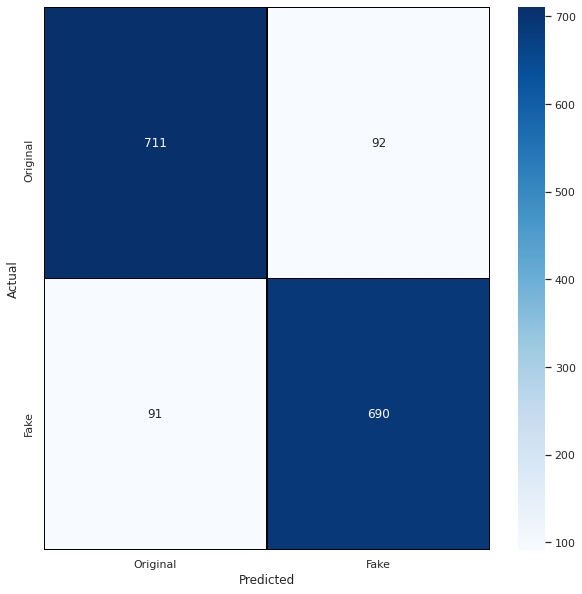

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Original','Fake'] , yticklabels = ['Original','Fake'])
plt.xlabel("Predicted")
plt.ylabel("Actual")

In [ ]:
from keras.layers import Dense,Embedding,LSTM,Dropout, Bidirectional,Input
from keras.layers.convolutional import Conv1D,MaxPooling1D
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:

WREG = 0.0001 # embedding regularization
CREG = 0.00001 # CNN regularization
RREG = 0.00001 # LSTM regularization
DREG = 0.00001 # Fully connected regularization
WDROP_RATE = 0.50 # embedding dropout
CDROP_RATE = 0.33 # CNN dropout
RDROP_RATE = 0.25 # LSTM dropout
DDROP_RATE = 0.15 # fully connected dropout
CHIDDEN_SIZE = 32 # CNN size
RHIDDEN_SIZE = 64 # LSTM size 
DHIDDEN_SIZE = 128 # fully connected size
SEQ_LEN = maxlen
EPOCH = 10
BATCH_SIZE = 256

# CNN+BiLSTM

In [ ]:
modelv2 = Sequential()
modelv2.add(Embedding(max_features, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False))
modelv2.add(Conv1D(filters = 128,kernel_regularizer=l2(CREG), 
              kernel_size=(3), 
              padding= "same", 
              strides=1,activation='relu'))
modelv2.add( MaxPooling1D(pool_size=2))
modelv2.add(Dropout(rate=CDROP_RATE))
modelv2.add(Bidirectional(LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25)))
modelv2.add(Bidirectional(LSTM(units=64 , recurrent_dropout = 0.1 , dropout = 0.25)))
modelv2.add(Dense(units = 32 , activation = 'relu'))
modelv2.add(Dense(1, activation='sigmoid'))
modelv2.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:

callbacks = [EarlyStopping(monitor = 'val_loss', patience = 10),
             ModelCheckpoint(filepath = 'best_model.h5', monitor= 'val_loss', save_best_only = True)]

In [ ]:
# train the model

history = modelv2.fit(x_train, y_train, batch_size = batch_size , validation_data = (X_test,y_test) , epochs = 20 , callbacks = [learning_rate_reduction])

Epoch 1/20
19/19 [==============================] - 164s 7s/step - loss: 0.6731 - accuracy: 0.6192 - val_loss: 0.5903 - val_accuracy: 0.6869
Epoch 2/20
19/19 [==============================] - 131s 7s/step - loss: 0.5362 - accuracy: 0.7250 - val_loss: 0.4885 - val_accuracy: 0.7588
Epoch 3/20
19/19 [==============================] - 129s 7s/step - loss: 0.4261 - accuracy: 0.8086 - val_loss: 0.4005 - val_accuracy: 0.8245
Epoch 4/20
19/19 [==============================] - 133s 7s/step - loss: 0.3702 - accuracy: 0.8420 - val_loss: 0.3509 - val_accuracy: 0.8441
Epoch 5/20
19/19 [==============================] - 130s 7s/step - loss: 0.2599 - accuracy: 0.8998 - val_loss: 0.3240 - val_accuracy: 0.8737
Epoch 6/20
19/19 [==============================] - 130s 7s/step - loss: 0.2154 - accuracy: 0.9227 - val_loss: 0.3069 - val_accuracy: 0.8838
Epoch 7/20
19/19 [==============================] - 130s 7s/step - loss: 0.1769 - accuracy: 0.9393 - val_loss: 0.3229 - val_accuracy: 0.8794
Epoch 8/20
19

In [ ]:
modelv2.save('/content/gdrive/MyDrive/Thesis/FakeorReal/cnnbilstm') 

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Thesis/FakeorReal/cnnbilstm/assets


In [ ]:
print("Accuracy of the model on Training Data is - " , modelv2.evaluate(x_train,y_train)[1]*100 , "%")
print("Accuracy of the model on Testing Data is - " , modelv2.evaluate(X_test,y_test)[1]*100 , "%")

149/149 [==============================] - 30s 203ms/step - loss: 0.0152 - accuracy: 0.9996
Accuracy of the model on Training Data is -  99.95790123939514 %
50/50 [==============================] - 10s 197ms/step - loss: 0.4053 - accuracy: 0.9053
Accuracy of the model on Testing Data is -  90.53030014038086 %


In [ ]:
pred = modelv2.predict_classes(X_test)
pred[:5]

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([[1],
       [0],
       [1],
       [1],
       [0]], dtype=int32)

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
f1 = f1_score(y_true=y_test, y_pred=pred)
print(f'f1: {f1}')

f1: 0.9044585987261147


In [ ]:
print(classification_report(y_test, pred, target_names = ['Original','Fake']))

              precision    recall  f1-score   support

    Original       0.91      0.90      0.91       803
        Fake       0.90      0.91      0.90       781

    accuracy                           0.91      1584
   macro avg       0.91      0.91      0.91      1584
weighted avg       0.91      0.91      0.91      1584



In [ ]:
cm = confusion_matrix(y_test,pred)
cm

array([[724,  79],
       [ 71, 710]])

In [ ]:
cm = pd.DataFrame(cm , index = ['Original','Fake'] , columns = ['Original','Fake'])

Text(66.5, 0.5, 'Actual')

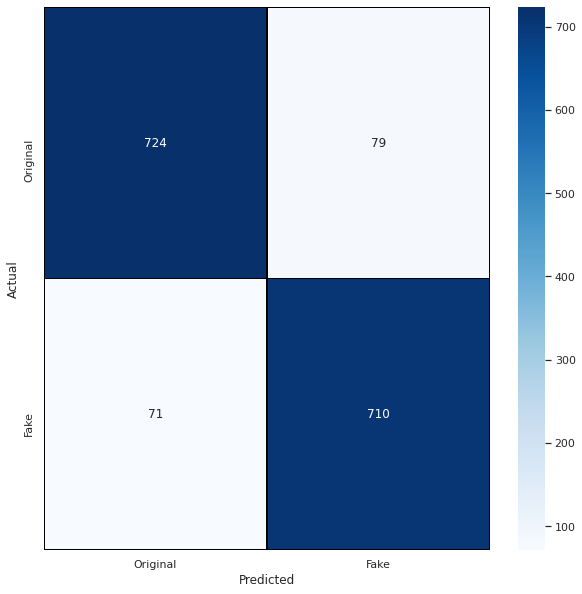

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Original','Fake'] , yticklabels = ['Original','Fake'])
plt.xlabel("Predicted")
plt.ylabel("Actual")

In [ ]:
from keras.layers import Dense,Embedding,LSTM,Dropout, Bidirectional,Input
from keras.layers.convolutional import Conv1D,MaxPooling1D
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:

WREG = 0.0001 # embedding regularization
CREG = 0.00001 # CNN regularization
RREG = 0.00001 # LSTM regularization
DREG = 0.00001 # Fully connected regularization
WDROP_RATE = 0.50 # embedding dropout
CDROP_RATE = 0.33 # CNN dropout
RDROP_RATE = 0.25 # LSTM dropout
DDROP_RATE = 0.15 # fully connected dropout
CHIDDEN_SIZE = 32 # CNN size
RHIDDEN_SIZE = 64 # LSTM size 
DHIDDEN_SIZE = 128 # fully connected size
EPOCH = 10
BATCH_SIZE = 256

# CNN-LSTM

In [ ]:
modelv4 = Sequential()
modelv4.add(Embedding(max_features, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False))
modelv4.add(Conv1D(filters = 128,kernel_regularizer=l2(CREG), 
              kernel_size=(3), 
              padding= "same", 
              strides=1,activation='relu'))
modelv4.add( MaxPooling1D(pool_size=2))
modelv4.add(Dropout(rate=CDROP_RATE))
modelv4.add(LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25))
modelv4.add(LSTM(units=64 , recurrent_dropout = 0.1 , dropout = 0.25))
modelv4.add(Dense(units = 32 , activation = 'relu'))
modelv4.add(Dense(1, activation='sigmoid'))
modelv4.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
# train the model

history = modelv4.fit(x_train, y_train, batch_size = batch_size , validation_data = (X_test,y_test) , epochs = 20 , callbacks = [learning_rate_reduction])

Epoch 1/20
19/19 [==============================] - 71s 3s/step - loss: 0.7107 - accuracy: 0.5657 - val_loss: 0.7986 - val_accuracy: 0.5720
Epoch 2/20
19/19 [==============================] - 58s 3s/step - loss: 0.5884 - accuracy: 0.7090 - val_loss: 0.5456 - val_accuracy: 0.7292
Epoch 3/20
19/19 [==============================] - 58s 3s/step - loss: 0.4884 - accuracy: 0.7871 - val_loss: 0.4937 - val_accuracy: 0.7891
Epoch 4/20
19/19 [==============================] - 58s 3s/step - loss: 0.4049 - accuracy: 0.8311 - val_loss: 0.4175 - val_accuracy: 0.8251
Epoch 5/20
19/19 [==============================] - 57s 3s/step - loss: 0.3828 - accuracy: 0.8362 - val_loss: 0.3860 - val_accuracy: 0.8371
Epoch 6/20
19/19 [==============================] - 58s 3s/step - loss: 0.3499 - accuracy: 0.8661 - val_loss: 0.4111 - val_accuracy: 0.8037
Epoch 7/20
19/19 [==============================] - 57s 3s/step - loss: 0.3352 - accuracy: 0.8622 - val_loss: 0.3295 - val_accuracy: 0.8769
Epoch 8/20
19/19 [==

In [ ]:
modelv4.save('/content/gdrive/MyDrive/Thesis/LIAR/cnnLstm') 

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Thesis/LIAR/cnnLstm/assets


In [ ]:
print("Accuracy of the model on Training Data is - " , modelv4.evaluate(x_train,y_train)[1]*100 , "%")
print("Accuracy of the model on Testing Data is - " , modelv4.evaluate(X_test,y_test)[1]*100 , "%")

149/149 [==============================] - 15s 101ms/step - loss: 0.0298 - accuracy: 0.9954
Accuracy of the model on Training Data is -  99.53693747520447 %
50/50 [==============================] - 5s 99ms/step - loss: 0.3736 - accuracy: 0.8965
Accuracy of the model on Testing Data is -  89.64646458625793 %


In [ ]:
pred = modelv4.predict_classes(X_test)
pred[:5]

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([[1],
       [0],
       [1],
       [1],
       [0]], dtype=int32)

In [ ]:
f1 = f1_score(y_true=y_test, y_pred=pred)
print(f'f1: {f1}')

f1: 0.8896366083445492


In [ ]:
print(classification_report(y_test, pred, target_names = ['Not Fake','Fake']))

              precision    recall  f1-score   support

    Not Fake       0.86      0.95      0.90       803
        Fake       0.94      0.85      0.89       781

    accuracy                           0.90      1584
   macro avg       0.90      0.90      0.90      1584
weighted avg       0.90      0.90      0.90      1584



In [ ]:
cm = confusion_matrix(y_test,pred)
cm

array([[759,  44],
       [120, 661]])

In [ ]:
cm = pd.DataFrame(cm , index = ['Original','Fake'] , columns = ['Original','Fake'])

Text(66.5, 0.5, 'Actual')

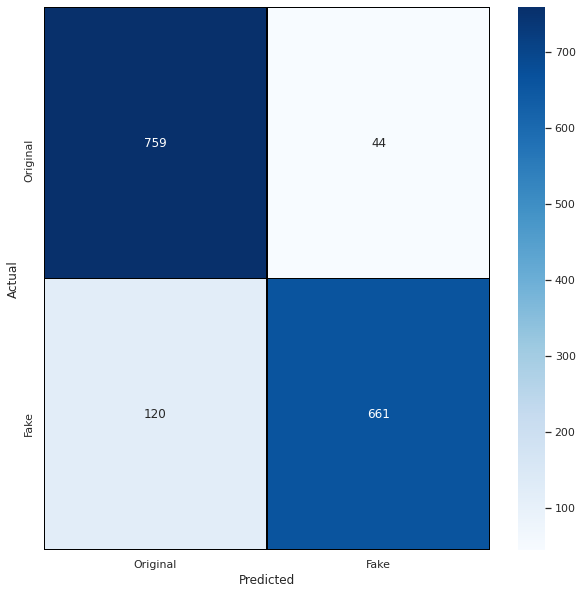

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Original','Fake'] , yticklabels = ['Original','Fake'])
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Bi-LSTM

In [ ]:
#giving vector features

embedding_vector_features = 40
model5 = Sequential()
model5.add(Embedding(max_features, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False))
model5.add(Dropout(0.4))
model5.add(Bidirectional(LSTM(100)))
model5.add(Dropout(0.4))
model5.add(Dense(1, activation = 'sigmoid'))
model5.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model5.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 300, 100)          1000000   
_________________________________________________________________
dropout_3 (Dropout)          (None, 300, 100)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200)               160800    
_________________________________________________________________
dropout_4 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 201       
Total params: 1,161,001
Trainable params: 161,001
Non-trainable params: 1,000,000
_________________________________________________________________


In [ ]:
# train the model

history = model5.fit(x_train, y_train, batch_size = batch_size , validation_data = (X_test,y_test) , epochs = 20 , callbacks = [learning_rate_reduction])

Epoch 1/20
19/19 [==============================] - 54s 3s/step - loss: 0.5901 - accuracy: 0.6853 - val_loss: 0.5658 - val_accuracy: 0.7014
Epoch 2/20
19/19 [==============================] - 55s 3s/step - loss: 0.4887 - accuracy: 0.7655 - val_loss: 0.4817 - val_accuracy: 0.7835
Epoch 3/20
19/19 [==============================] - 54s 3s/step - loss: 0.4526 - accuracy: 0.7901 - val_loss: 0.4840 - val_accuracy: 0.7847
Epoch 4/20
19/19 [==============================] - 55s 3s/step - loss: 0.4174 - accuracy: 0.8087 - val_loss: 0.4548 - val_accuracy: 0.8062
Epoch 5/20
19/19 [==============================] - 55s 3s/step - loss: 0.4118 - accuracy: 0.8184 - val_loss: 0.4369 - val_accuracy: 0.8100
Epoch 6/20
19/19 [==============================] - 56s 3s/step - loss: 0.4028 - accuracy: 0.8282 - val_loss: 0.4590 - val_accuracy: 0.7992
Epoch 7/20
19/19 [==============================] - 55s 3s/step - loss: 0.4348 - accuracy: 0.7960 - val_loss: 0.4516 - val_accuracy: 0.8024

Epoch 00007: Reduce

In [ ]:
model5.save('/content/gdrive/MyDrive/Thesis/FakeorReal/BiLSTM') 

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Thesis/FakeorReal/BiLSTM/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Thesis/FakeorReal/BiLSTM/assets


In [ ]:
print("Accuracy of the model on Training Data is - " , model5.evaluate(x_train,y_train)[1]*100 , "%")
print("Accuracy of the model on Testing Data is - " , model5.evaluate(X_test,y_test)[1]*100 , "%")

149/149 [==============================] - 16s 108ms/step - loss: 0.3606 - accuracy: 0.8600
Accuracy of the model on Training Data is -  86.00294589996338 %
50/50 [==============================] - 5s 108ms/step - loss: 0.4226 - accuracy: 0.8396
Accuracy of the model on Testing Data is -  83.96464586257935 %


In [ ]:
pred = model5.predict_classes(X_test)
pred[:5]

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([[1],
       [0],
       [1],
       [1],
       [0]], dtype=int32)

In [ ]:
f1 = f1_score(y_true=y_test, y_pred=pred)
print(f'f1: {f1}')

f1: 0.8272108843537416


In [ ]:
print(classification_report(y_test, pred, target_names = ['Original','Fake']))

              precision    recall  f1-score   support

    Original       0.81      0.90      0.85       803
        Fake       0.88      0.78      0.83       781

    accuracy                           0.84      1584
   macro avg       0.84      0.84      0.84      1584
weighted avg       0.84      0.84      0.84      1584



In [ ]:
cm = confusion_matrix(y_test,pred)
cm

array([[722,  81],
       [173, 608]])

In [ ]:
cm = pd.DataFrame(cm , index = ['Fake','Original'] , columns = ['Original','Fake'])

Text(66.5, 0.5, 'Actual')

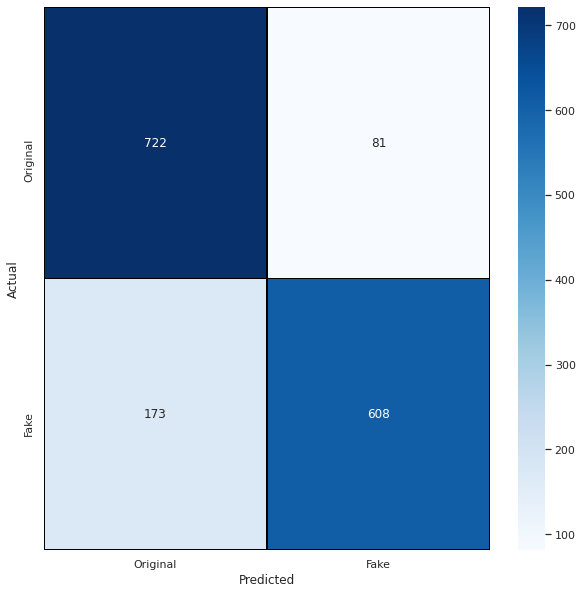

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Original','Fake'] , yticklabels = ['Original','Fake'])
plt.xlabel("Predicted")
plt.ylabel("Actual")

# GRU

In [ ]:
from tensorflow.keras.layers import Dense, Dropout, Embedding, GRU, LSTM, RNN, SpatialDropout1D

In [ ]:
#Defining Neural Network
model6 = Sequential()
#Non-trainable embeddidng layer
model6.add(Embedding(max_features, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False))
#LSTM 
model6.add(GRU(units=128 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25))
model6.add(GRU(units=64 , recurrent_dropout = 0.1 , dropout = 0.1))
model6.add(Dense(units = 32 , activation = 'relu'))
model6.add(Dense(1, activation='sigmoid'))
model6.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
# train the model

history = model6.fit(x_train, y_train, batch_size = batch_size , validation_data = (X_test,y_test) , epochs = 20 , callbacks = [learning_rate_reduction])

Epoch 1/20
19/19 [==============================] - 92s 4s/step - loss: 0.6903 - accuracy: 0.5725 - val_loss: 0.6184 - val_accuracy: 0.6894
Epoch 2/20
19/19 [==============================] - 76s 4s/step - loss: 0.5089 - accuracy: 0.7489 - val_loss: 0.4274 - val_accuracy: 0.8062
Epoch 3/20
19/19 [==============================] - 76s 4s/step - loss: 0.3947 - accuracy: 0.8280 - val_loss: 0.3401 - val_accuracy: 0.8535
Epoch 4/20
19/19 [==============================] - 76s 4s/step - loss: 0.2719 - accuracy: 0.8886 - val_loss: 0.2731 - val_accuracy: 0.8876
Epoch 5/20
19/19 [==============================] - 76s 4s/step - loss: 0.2074 - accuracy: 0.9184 - val_loss: 0.2543 - val_accuracy: 0.8952
Epoch 6/20
19/19 [==============================] - 76s 4s/step - loss: 0.1741 - accuracy: 0.9322 - val_loss: 0.2182 - val_accuracy: 0.9148
Epoch 7/20
19/19 [==============================] - 77s 4s/step - loss: 0.1184 - accuracy: 0.9542 - val_loss: 0.2165 - val_accuracy: 0.9211
Epoch 8/20
19/19 [==

In [ ]:
print("Accuracy of the model on Training Data is - " , model6.evaluate(x_train,y_train)[1]*100 , "%")
print("Accuracy of the model on Testing Data is - " , model6.evaluate(X_test,y_test)[1]*100 , "%")

149/149 [==============================] - 19s 125ms/step - loss: 0.0023 - accuracy: 0.9994
Accuracy of the model on Training Data is -  99.93685483932495 %
50/50 [==============================] - 6s 121ms/step - loss: 0.3087 - accuracy: 0.9306
Accuracy of the model on Testing Data is -  93.05555820465088 %


In [ ]:
pred = model6.predict_classes(X_test)
pred[:5]

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([[1],
       [0],
       [1],
       [1],
       [0]], dtype=int32)

In [ ]:
print(classification_report(y_test, pred, target_names = ['Original','Fake']))

              precision    recall  f1-score   support

    Original       0.93      0.94      0.93       803
        Fake       0.93      0.92      0.93       781

    accuracy                           0.93      1584
   macro avg       0.93      0.93      0.93      1584
weighted avg       0.93      0.93      0.93      1584



In [ ]:
cm = confusion_matrix(y_test,pred)
cm

array([[752,  51],
       [ 59, 722]])

In [ ]:
cm = pd.DataFrame(cm , index = ['Fake','Original'] , columns = ['Original','Fake'])

Text(66.5, 0.5, 'Actual')

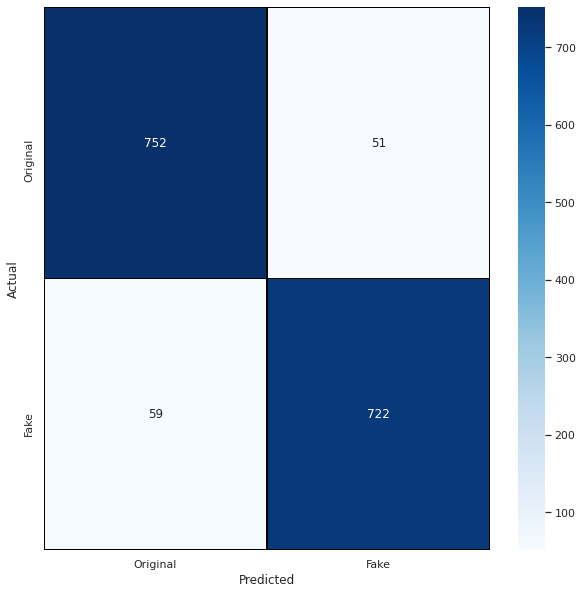

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Original','Fake'] , yticklabels = ['Original','Fake'])
plt.xlabel("Predicted")
plt.ylabel("Actual")